In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import tensorflow

In [2]:
import yaml

with open('reg_defs.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [3]:
features

['pfcand_pt_log_nopuppi',
 'pfcand_e_log_nopuppi',
 'pfcand_etarel',
 'pfcand_phirel',
 'pfcand_abseta',
 'pfcand_charge',
 'pfcand_isMu',
 'pfcand_isEl',
 'pfcand_isChargedHad',
 'pfcand_isGamma',
 'pfcand_isNeutralHad',
 'pfcand_VTX_ass',
 'pfcand_lostInnerHits',
 'pfcand_normchi2',
 'pfcand_quality',
 'pfcand_dz',
 'pfcand_dzsig',
 'pfcand_dxy',
 'pfcand_dxysig']

In [4]:
labels

['fj_genjetmsd']

In [5]:
from RegDataGenerator import DataGenerator
help(DataGenerator)

Help on class DataGenerator in module RegDataGenerator:

class DataGenerator(tensorflow.python.keras.utils.data_utils.Sequence)
 |  DataGenerator(list_files, features, labels, spectators, batch_size=1024, n_dim=60, remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False, max_entry=20000, scale_mass_pt=[1, 1])
 |  
 |  Generates data for Keras
 |  
 |  Method resolution order:
 |      DataGenerator
 |      tensorflow.python.keras.utils.data_utils.Sequence
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Generate one batch of data
 |  
 |  __init__(self, list_files, features, labels, spectators, batch_size=1024, n_dim=60, remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False, max_entry=20000, scale_mass_pt=[1, 1])
 |      Initialization
 |  
 |  __len__(self)
 |      Denotes the number of batches per epoch
 |  
 |  on_epoch_end(self)
 |      Updates indexes after each epoch
 |  
 |  ----------------

In [6]:
# load training and validation generators 
train_files = ['/teams/DSC180A_FA21_A00/a11/train_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_1-1_Skim.root',
               '/teams/DSC180A_FA21_A00/a11/train_mass_qcd/QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/nano_mc2017_1-101_Skim.root',
               '/teams/DSC180A_FA21_A00/a11/train_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_1-12_Skim.root',
              ]
val_files = ['/teams/DSC180A_FA21_A00/a11/train_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_2-3_Skim.root']

train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=False, max_entry=20000)

val_generator = DataGenerator(val_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=False, max_entry=2000)

In [7]:
X, y = train_generator[1]
print(X.shape)
print(y.shape)

(1024, 100, 19)
(1024, 1)


In [8]:
# X, y = val_generator[1]
# print(X.shape)
# print(y.shape)

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten
from tensorflow.keras.optimizers import RMSprop
#from rbflayer import RBFLayer, InitCentersRandom
import tensorflow.keras.backend as K
import pandas as pd

In [10]:
Flatten()(X)[0].shape

TensorShape([1900])

In [11]:
# rbfmodel = Sequential()
# rbflayer = RBFLayer(10,initializer=InitCentersRandom(Flatten()(X)),betas=1.0,input_shape=(1900,))
# #rbfmodel.add(Flatten())
# rbfmodel.add(rbflayer)
# rbfmodel.add(Dense(1))
# rbfmodel.compile(loss='mean_squared_error', optimizer=RMSprop())
# rbfmodel.fit(X,y,max_queue_size=5,epochs=100,shuffle=False,verbose=0)

In [12]:
# define dense keras model
inputs = Input(shape=(ntracks, nfeatures,), name='input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Flatten(name='flatten_1')(x)
x = Dense(100, name='dense_1', activation='relu')(x)
x = Dense(100, name='dense_2', activation='relu')(x)
x = Dense(50, name='dense_3', activation='relu')(x)
x = Dense(19, name='dense_4', activation='relu')(x)
outputs = Dense(nlabels, name='output', activation='linear')(x)
keras_model_dense = Model(inputs=inputs, outputs=outputs)
keras_model_dense.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(keras_model_dense.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 19)]         0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 100, 19)           76        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1900)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               190100    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 19)                969   

In [24]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_dense_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
history_dense = keras_model_dense.fit(train_generator,
                                      validation_data=val_generator,
                                      steps_per_epoch=len(train_generator),
                                      validation_steps=len(val_generator),
                                      max_queue_size=5,
                                      epochs=40,
                                      shuffle=False,
                                      verbose=0
                                      ,callbacks=callbacks)
                                      
# reload best weights
keras_model_dense.load_weights('keras_model_dense_best.h5')

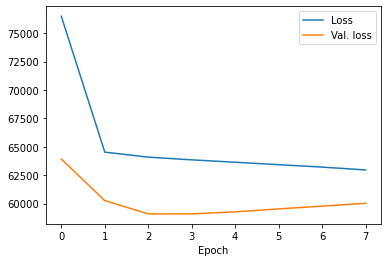

In [25]:
plt.figure()
plt.plot(history_dense.history['loss'], label='Loss')
plt.plot(history_dense.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
keras_model_dense.load_weights('keras_model_dense_best.h5')

In [14]:
test_files = ["/home/dmngo/teams/DSC180A_FA21_A00/a11/test_mass_hbb/BulkGravitonToHHTo4Q_MX-600to6000_MH-15to250_part1_TuneCP5_13TeV-madgraph_pythia8/nano_mc2017_3-10_Skim.root"]
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=False, max_entry=2000)

AttributeError: 'DataGenerator' object has no attribute 'shape'

(array([[[ 5.99955654e+00,  6.07747316e+00,  2.45513916e-01, ...,
           1.00000000e+00, -1.00000000e+00,  1.00000000e+00],
         [ 5.69960690e+00,  5.85531330e+00,  4.18243408e-01, ...,
           1.00000000e+00, -1.00000000e+00,  1.00000000e+00],
         [ 5.64456320e+00,  5.79995394e+00,  4.17633057e-01, ...,
          -3.62761497e+00, -3.77464294e-03, -2.14061666e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 6.18929052e+00,  6.35543346e+00, -1.15368652e+00, ...,
           1.00000000e+00, -1.00000000e+00,  1.00000000e+00],
         [ 6.18105125e+00,  6.36005259e+00, -1.17749023e+00, ...,
          -7.55149841

In [20]:
predict.shape

(2000, 1)

In [27]:
keras_model_dense.predict(X)

array([[251.72932],
       [272.85217],
       [248.63312],
       ...,
       [245.64848],
       [266.4166 ],
       [192.61433]], dtype=float32)